In [6]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os

from image_utils import *
from template_matching import *

dicom_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS25")
segmentation_path = os.path.join("boneMRI", "20240304_BoneMRI_EBS25_Segmentation.nii")

# get 50 random angles to template match
# differentiate lumbar and thoracic
# check what vertebrae works best
# check why it is not working for what vertebrae

The shape of the image is (100, 672, 672)


Text(0.5, 1.0, 'Applied segmentation mask')

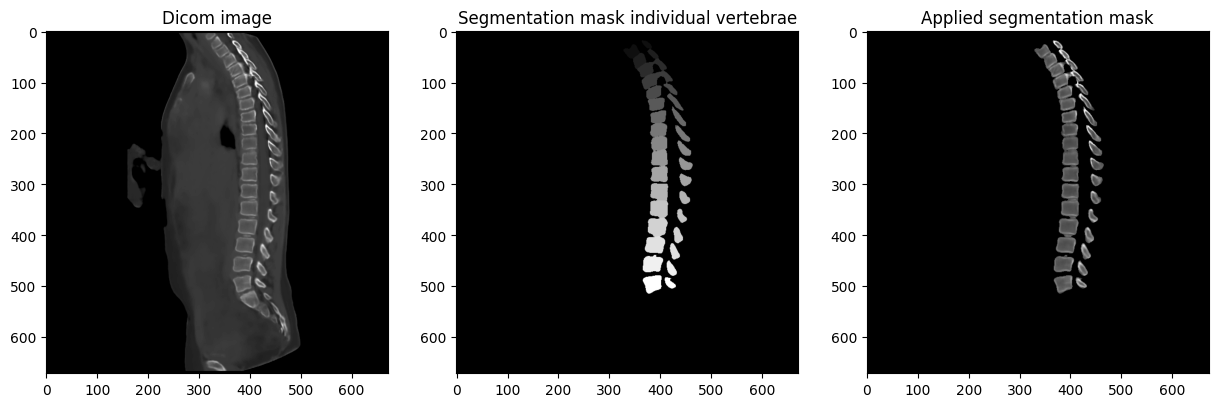

In [7]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask")

In [ ]:
euler_angles = get_euler_angles(segment_data)
vertebrae_labels = np.unique(segment_data)[1:]
bounds = [(-45, 45), (0, 0), (-15, 15)]  # Bounds the sagittal, coronal, and axial angles
optimized_angles = {}

for label in vertebrae_labels:
    generate_template(segment_dicom_image, segment_data, label, euler_angles)
    ROI_3D_image, ref_3D_image, rotated_image, rotated_mask = make_input_3D_ROI(segment_dicom_image, segment_data, label, euler_angles, saggital_angle=0, coronal_angle=0, axial_angle=0)
    
    template_nii = nib.load(f'template_image.nii')
    template = template_nii.get_fdata().astype(np.float32)
    
    if template.shape[0] == 0 or template.shape[1] == 0:
        print(f"Skipping label {label} as the template is empty")
        continue
    # Optimize the rotation angles
    optimal_angles = optimize_rotation(ROI_3D_image, template, bounds)
    optimized_angles[label] = optimal_angles
    print(f"Best Angles for label {label}: Saggital={optimal_angles[0]} degrees, Coronal={optimal_angles[1]} degrees, Axial={optimal_angles[2]} degrees")

Computed bounding box for 17 vertebra
The updated euler angles after initial rotation are:  [-27.78579133  -3.1028461   -1.21936889]
Best Angles for label 1: Saggital=-26.09523786599889 degrees, Coronal=0.0 degrees, Axial=-1.6380628054485313 degrees
The updated euler angles after initial rotation are:  [-29.21568046   8.81203214  -1.41405364]
Best Angles for label 2: Saggital=-44.99995804408395 degrees, Coronal=0.0 degrees, Axial=-1.8144325711885623 degrees
The updated euler angles after initial rotation are:  [-21.43196895  15.85682436  -0.96155072]
Best Angles for label 3: Saggital=12.080535511613334 degrees, Coronal=0.0 degrees, Axial=-0.9374103157690217 degrees
The updated euler angles after initial rotation are:  [-17.83514421   4.43487355  -0.52785006]
Best Angles for label 4: Saggital=9.154155005132017 degrees, Coronal=0.0 degrees, Axial=0.5900065200092808 degrees
The updated euler angles after initial rotation are:  [-14.10468197  -4.71432998  -0.46679712]
Best Angles for label

Sagittal MAE: 7.038
Sagittal ME: 4.408
Sagittal Pearson r: 0.802
Axial MAE: 1.828
Axial ME: 1.161
Axial Pearson r: 0.097


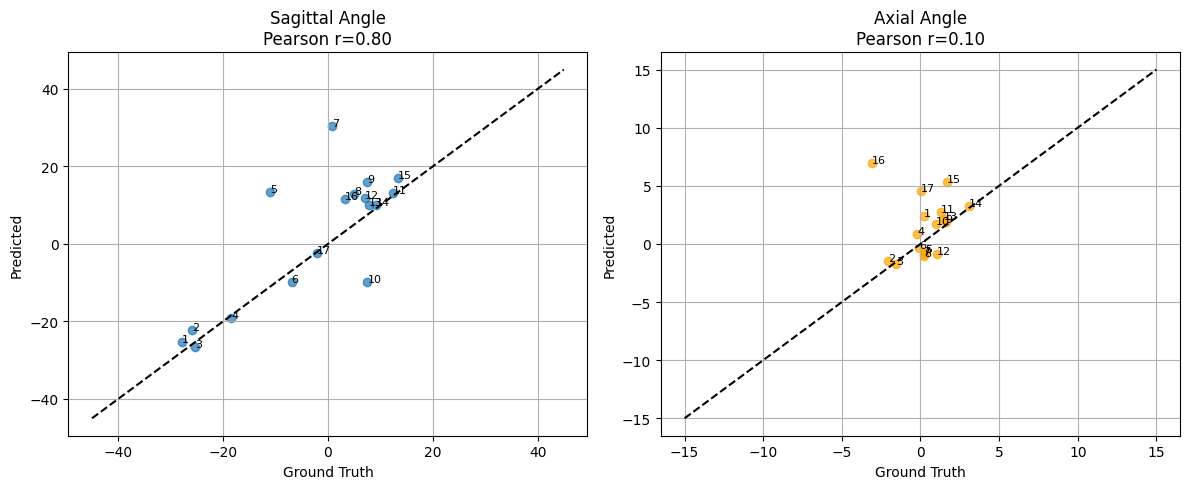

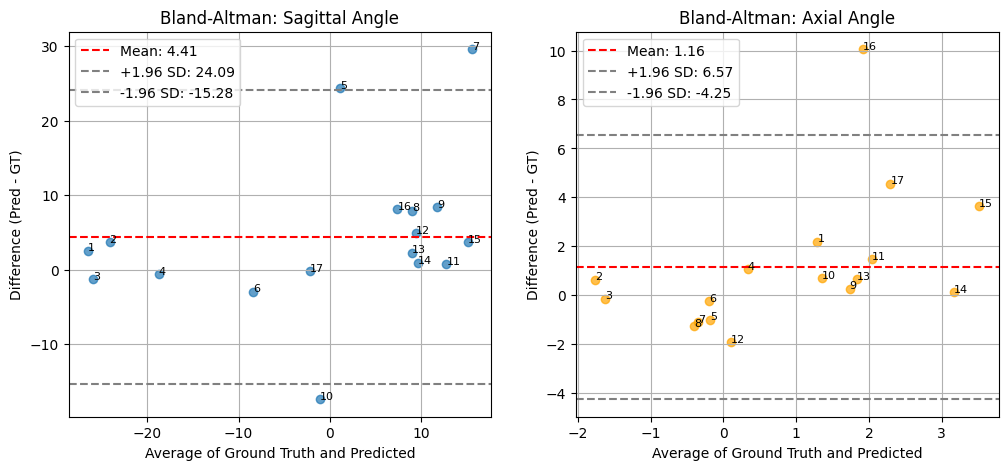

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract angle data
labels = optimized_angles.keys()

sag_gt = np.array([euler_angles[label][0] for label in labels])
sag_pred = np.array([optimized_angles[label][0] for label in labels])
ax_gt = np.array([euler_angles[label][2] for label in labels])
ax_pred = np.array([optimized_angles[label][2] for label in labels])

# Errors
sag_error = sag_pred - sag_gt
ax_error = ax_pred - ax_gt

# MAE & ME
sag_mae = np.mean(np.abs(sag_error))
sag_me = np.mean(sag_error)
ax_mae = np.mean(np.abs(ax_error))
ax_me = np.mean(ax_error)

# Pearson correlation
sag_corr, _ = pearsonr(sag_gt, sag_pred)
ax_corr, _ = pearsonr(ax_gt, ax_pred)

print(f"Sagittal MAE: {sag_mae:.3f}", )
print(f"Sagittal ME: {sag_me:.3f}")
print(f"Sagittal Pearson r: {sag_corr:.3f}")

print(f"Axial MAE: {ax_mae:.3f}", )
print(f"Axial ME: {ax_me:.3f}")
print(f"Axial Pearson r: {ax_corr:.3f}")

# Scatter plot
plt.figure(figsize=(12, 5))

# Sagittal scatter
plt.subplot(1, 2, 1)
plt.scatter(sag_gt, sag_pred, alpha=0.7)
plt.plot([-45, 45], [-45, 45], 'k--')
for i, label in enumerate(labels):
    plt.text(sag_gt[i], sag_pred[i], str(label), fontsize=8)
plt.title(f'Sagittal Angle\nPearson r={sag_corr:.2f}')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

# Axial scatter
plt.subplot(1, 2, 2)
plt.scatter(ax_gt, ax_pred, alpha=0.7, color='orange')
plt.plot([-15, 15], [-15, 15], 'k--')
for i, label in enumerate(labels):
    plt.text(ax_gt[i], ax_pred[i], str(label), fontsize=8)
plt.title(f'Axial Angle\nPearson r={ax_corr:.2f}')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# Bland-Altman plot
def bland_altman_plot(gt, pred, labels, title):
    
    plt.figure(figsize=(12, 5))
    
    for i in range(len(gt)):
        avg = (gt[i] + pred[i]) / 2
        diff = pred[i] - gt[i]
        mean_diff = np.mean(diff)
        std_diff = np.std(diff)
        loa_upper = mean_diff + 1.96 * std_diff
        loa_lower = mean_diff - 1.96 * std_diff

        plt.subplot(1, len(gt), i+1)
        if i == 1:
            plt.scatter(avg, diff, alpha=0.7, color='orange')
        else:
            plt.scatter(avg, diff, alpha=0.7)
        for j, label in enumerate(labels):
            plt.text(avg[j], diff[j], str(label), fontsize=8)
        plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.2f}')
        plt.axhline(loa_upper, color='gray', linestyle='--', label=f'+1.96 SD: {loa_upper:.2f}')
        plt.axhline(loa_lower, color='gray', linestyle='--', label=f'-1.96 SD: {loa_lower:.2f}')
        plt.title(f'Bland-Altman: {title[i]}')
        plt.xlabel('Average of Ground Truth and Predicted')
        plt.ylabel('Difference (Pred - GT)')
        plt.legend()
        plt.grid(True)
        
    plt.show()

# Usage with labels
bland_altman_plot([sag_gt, ax_gt], [sag_pred, ax_pred], list(labels), ['Sagittal Angle', 'Axial Angle'])
